# Laboratorio ERF

>Trabalho Prático n.º 5

## Projecto de um filtro passa-banda

1. Projecte um filtro passa-banda com as seguintes características:
    - Impedância característica $Z_0=50 \Omega$.
    - Banda $L$ ou $S$ (com largura de banda inferior a 20%).
    - $20\ dB$ de atenuação a 15% da frequência central $f_c$.
    - Perdas por inserção inferiores a $3\ dB$.

> Laminado: Rogers, RO4003C ($H=0.508mm$,$εr=3.55$, $tan_D=0.0021$)



a) Escolha um tipo de filtro (equal-ripple, maximally flat ou maximally flat time delay) justificando com uma possível aplicação prática para o filtro projectado.

In [6]:
## VARIABLES
n = 3 # order
z0 = 50 # Impedancia Caracteristicas
H = 0.508e-3 #m Altura do material
e_r = 3.55 # Permissividade 
tan_D = 0.0021 # 
#freq = 5e6 # Hz


/tmp/ipykernel_783945/2191008421.py:8: DeprecationWarning: 
                          Frequency unit not passed: currently uses 'GHz' per default.
                          The future versions of scikit-rf will use 'Hz' per default instead,
                          so it is recommended to specify explicitly the frequency unit
                          to obtain similar results with future versions.
                          
  freq = rf.Frequency(5e6)


b) Projecte e simule um protótipo do filtro usando elementos discretos
(condensadores e bobines).


In [2]:
%pip install scikit-rf
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np  # for np.allclose() to check that S-params are similar
import skrf as rf
rf.stylely()

Matplotlib is building the font cache; this may take a moment.


In [16]:
# scikit-rf: the filter by cascading all lumped-elements
freq = rf.Frequency(0,10,100,'ghz')
line = rf.media.DefinedGammaZ0(frequency=freq, z0=z0)
passband_manual = line.shunt_capacitor(25.406e-12) ** line.shunt_inductor(4.154e-9) ** \
                  line.capacitor(2.419e-12) ** line.inductor(43.636e-9) ** \
                  line.shunt_capacitor(25.406e-12) ** line.shunt_inductor(4.154e-9)

In [17]:
# scikit-rf: the filter with the Circuit builder

line = rf.media.DefinedGammaZ0(frequency=freq)
C1 = line.capacitor(25.406e-12, name='C1')
C2 = line.capacitor(2.419e-12, name='C2')
C3 = line.capacitor(25.406e-12, name='C3')
L1 = line.inductor(4.154e-9, name='L1')
L2 = line.inductor(43.636e-9, name='L2')
L3 = line.inductor(4.154e-9, name='L3')
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=50)
ground =  rf.Circuit.Ground(frequency=freq, name='ground', z0=50)

connections = [
    [(port1, 0), (C1, 0), (L1, 0), (C2, 0)],
    [(C2, 1), (L2, 0)],
    [(L2, 1), (C3, 0), (L3, 0), (port2, 0)],
    [(C1, 1), (C3, 1), (L1, 1), (L3, 1), (ground, 0)],
]

circuit = rf.Circuit(connections)
passband_circuit = circuit.network
passband_circuit.name = 'Pass-band circuit'

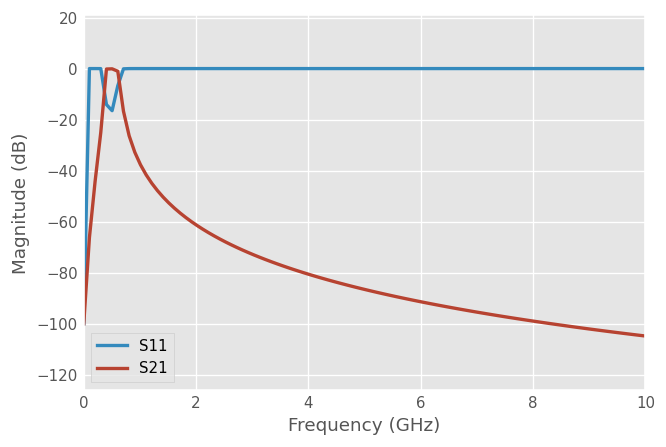

In [19]:
passband_manual.plot_s_db(m=0, n=0, lw=2)
passband_manual.plot_s_db(m=1, n=0, lw=2)

c) Projecte e simule o filtro usando uma implementação em microstrip coupled lines.



d) Faça uma implementação final do filtro e sua optimização usando uma
implementação em hairpin.



e) Faça a simulação electromagnética do layout do filtro e compare os resultados
obtidos.
Nota: Ver livros “Microwave Engineering”, David M. Pozar e “HF Filter Design and
Computer Simulation”, Randall W. Rhea.